In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 28 00:30:52 2019

@author: jerryyao
"""

import numpy as np

from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from graspy.embed import CovariateAssistedSpectralEmbed
from graspy.embed import LaplacianSpectralEmbed
from graspy.simulations import sbm
from graspy.plot import heatmap, pairplot
from sklearn.metrics import adjusted_rand_score as ARI
import graspy

import time
def GraphCovaritesSimulater(covProb,labels,agreement):
    time_start=time.time()
    base=np.eye(max(labels)+1)
    membership=np.zeros([len(labels),covProb.shape[1]])
    n_misassign=0
    for i in range (0,len(labels)):
        assignRV=bool(np.random.binomial(1,agreement))
        if assignRV:
            membership[i,:]=base[labels[i],:]
        else:
            membership[i,:]=base[(labels[i]+1)%(max(labels)+1),:]
            n_misassign=n_misassign+1
    agreement_=1-n_misassign/(len(labels))
    probMat=np.dot(membership,covProb)
    covMat=np.zeros(probMat.shape)
    for i in range(0,covMat.shape[0]):
        for j in range(0,covMat.shape [1]):
            covMat[i,j]=np.random.binomial(1,probMat[i,j])
    time_end=time.time()
    print('tcovgen',(time_end-time_start)*1000,'ms')
    return covMat,agreement_,membership
        
def simulation(p,q,m1,m2,assortative,CCA,agreement):
    n_verts = 1500
    labels_sbm = n_verts * [0] + n_verts * [1]+n_verts * [2]
    if assortative:
        P = np.array([[p,q,q],[q,p,q],[q,q,p]])
    else:
        P = np.array([[q,p,p],[p,q,p],[p,p,q]])
    undirected_sbm = sbm(3 * [n_verts], P)
    #    heatmap(undirected_sbm, title='2-block SBM (undirected)', inner_hier_labels=labels_sbm)
    
#    nMembers=[150,150,150]
    covProbMat = np.matrix([[m1,m2,m2],[m2,m1,m2],[m2,m2,m1]])
    
    covMat,agreement_,membership = GraphCovaritesSimulater(covProbMat,labels_sbm,agreement)
    
    time_start=time.time()
    ase = graspy.embed.CovariateAssistedSpectralEmbed(n_components=3,assortative=True,CCA=True,check_lcc=False)
    Xhat = ase.fit(undirected_sbm,covMat) 
    loss_casc_cca=(1-ARI(Xhat['cluster'],labels_sbm))
    
    time_end=time.time()
    print('tCCA',(time_end-time_start)*1000,'ms')
    
    time_start=time.time()
    ase = graspy.embed.CovariateAssistedSpectralEmbed(n_components=3,assortative=True,check_lcc=False)
    Xhat = ase.fit(undirected_sbm,covMat)
    loss_casc_assortative=(1-ARI(Xhat['cluster'],labels_sbm))

    time_end=time.time()
    print('tasscasc',(time_end-time_start)*1000,'ms')
    
    time_start=time.time()
    ase = graspy.embed.CovariateAssistedSpectralEmbed(n_components=3,assortative=False,check_lcc=False)
    Xhat = ase.fit(undirected_sbm,covMat)
    loss_casc=(1-ARI(Xhat['cluster'],labels_sbm))
    
    time_end=time.time()
    print('tcasc',(time_end-time_start)*1000,'ms')

    time_start=time.time()

    lse =LaplacianSpectralEmbed(form='R-DAD',regularizer=1,n_components=3,check_lcc=False)
    X1hat = lse.fit_transform(undirected_sbm)
    kmeansResults=KMeans(n_clusters=3).fit(X1hat)
    labels=kmeansResults.labels_
    loss_regulrized_lse=(1-ARI(labels,labels_sbm))
    
    time_end=time.time()
    print('tlse',(time_end-time_start)*1000,'ms')
    
    time_start=time.time()

#pairplot(Xhat['cascSvd'], title='SBM casc embeddingCC')
    lse =LaplacianSpectralEmbed(form='R-DAD',regularizer=1,n_components=3,check_lcc=False)
    X1hat = lse.fit_transform(np.dot(covMat,covMat.transpose()))
    kmeansResults=KMeans(n_clusters=3).fit(X1hat)
    labels=kmeansResults.labels_
    loss_cov_lse=(1-ARI(labels,labels_sbm))
    
    time_end=time.time()
    print('tcov',(time_end-time_start)*1000,'ms')
#    ase = graspy.embed.casc_new.CovariateAssistedSpectralEmbed(n_components=4,assortative=True,CCA=True)
#    Xhat = ase.fit(undirected_sbm,covMat) 
#    loss_casc_cca=(1-ARI(Xhat['cluster'],labels_sbm))
    
    return[loss_cov_lse,loss_regulrized_lse,loss_casc_assortative,loss_casc,loss_casc_cca],agreement_
    

p=0.0225
q=0.015
m1=0.8
m2=0.2
loss5=np.zeros((40,5))
agreementMat=np.zeros((40,1))
for i in range(0,40):
    print(i)
    loss5[i,:],agreementMat[i]=simulation(p,q,m1,m2,True,False,0.6+i*0.01)

#    

p=0.0225
q=0.015
m1=0.8
m2=0.2
loss6=np.zeros((40,5))
agreementMat=np.zeros((40,1))
for i in range(0,40):
    print(i)
    loss6[i,:],agreementMat[i]=simulation(p,q,m1,m2,False,False,0.6+i*0.01)
   






    
p=0.015
q=0.015
m1=0.8
m2=0.2
loss=np.zeros((25,5))
for i in range(0,25):
    print(i)
    loss[i,:]=simulation(p+i*0.001,q,m1,m2,True,False,1)[0]
    
p=0.015
q=0.015
m1=0.8
m2=0.2    
loss1=np.zeros((25,5))
for i in range(0,25):
    print(i)
    loss1[i,:]=simulation(p+i*0.001,q,m1,m2,False,False,1)[0]
    
p=0.0225
q=0.015
m1=0.2
m2=0.2

loss2=np.zeros((75,5))
for i in range(0,75):
    loss2[i,:]=simulation(p,q,m1+0.01*i,m2,True,False,1)[0]
    
    
p=0.0225
q=0.015
m1=0.2
m2=0.2
    
loss3=np.zeros((75,5))
for i in range(0,75):
    loss3[i,:]=simulation(p,q,m1+0.01*i,m2,False,False,1)[0]
    
    
#    
#    
#    

0
tcovgen 210.4361057281494 ms
tCCA 5787.055015563965 ms
tasscasc 87739.81952667236 ms
tcasc 50848.90818595886 ms
tlse 5517.233371734619 ms
tcov 5597.019910812378 ms
1
tcovgen 227.4179458618164 ms
tCCA 5237.978219985962 ms
tasscasc 67630.9928894043 ms
tcasc 49935.35351753235 ms
tlse 5812.4425411224365 ms
tcov 5679.797887802124 ms
2
tcovgen 195.47700881958008 ms
tCCA 5166.17226600647 ms
tasscasc 69474.06125068665 ms
tcasc 49521.46029472351 ms
tlse 5440.439939498901 ms
tcov 5528.204441070557 ms
3
tcovgen 199.46622848510742 ms
tCCA 5194.09966468811 ms
tasscasc 70804.49771881104 ms
tcasc 49320.5144405365 ms
tlse 5458.391189575195 ms
tcov 5539.174556732178 ms
4
tcovgen 187.4992847442627 ms
tCCA 5109.324216842651 ms
tasscasc 72614.58039283752 ms
tcasc 51834.32364463806 ms
tlse 6475.627183914185 ms
tcov 8693.7997341156 ms
5
tcovgen 344.8052406311035 ms
tCCA 8112.4749183654785 ms
tasscasc 108224.6150970459 ms
tcasc 75257.70497322083 ms
tlse 8873.265743255615 ms
tcov 8610.053062438965 ms
6
tcov

tCCA 5216.039180755615 ms
tasscasc 61977.1249294281 ms
tcasc 44999.56488609314 ms
tlse 5460.38556098938 ms
tcov 5387.607574462891 ms
10
tcovgen 174.53312873840332 ms
tCCA 5048.487186431885 ms
tasscasc 62262.36176490784 ms
tcasc 45229.947566986084 ms
tlse 5483.3245277404785 ms
tcov 5502.273082733154 ms
11
tcovgen 170.54224014282227 ms
tCCA 5112.317323684692 ms
tasscasc 61426.5992641449 ms
tcasc 44834.0060710907 ms
tlse 5523.218154907227 ms
tcov 5349.680662155151 ms
12
tcovgen 168.5483455657959 ms
tCCA 5031.534194946289 ms
tasscasc 62539.61944580078 ms
tcasc 46391.83783531189 ms
tlse 5440.438985824585 ms
tcov 5468.364715576172 ms
13
tcovgen 171.5397834777832 ms
tCCA 5138.2482051849365 ms
tasscasc 64576.16829872131 ms
tcasc 44522.84002304077 ms
tlse 5434.439420700073 ms
tcov 5397.553205490112 ms
14
tcovgen 163.56253623962402 ms
tCCA 5077.410459518433 ms
tasscasc 62023.003816604614 ms
tcasc 44747.23720550537 ms
tlse 5457.393407821655 ms
tcov 5392.56739616394 ms
15
tcovgen 142.6165103912353

tCCA 5160.188913345337 ms
tasscasc 52636.125326156616 ms
tcasc 44600.63147544861 ms
tlse 5452.407598495483 ms
tcov 5690.7689571380615 ms
19
tcovgen 75.79708099365234 ms
tCCA 5172.157526016235 ms
tasscasc 58519.38009262085 ms
tcasc 44398.1716632843 ms
tlse 5476.343870162964 ms
tcov 5834.385395050049 ms
20
tcovgen 79.78534698486328 ms
tCCA 5201.079607009888 ms
tasscasc 56099.854946136475 ms
tcasc 43894.521951675415 ms
tlse 5484.321117401123 ms
tcov 5765.568971633911 ms
21
tcovgen 77.79192924499512 ms
tCCA 5564.10813331604 ms
tasscasc 54563.966035842896 ms
tcasc 44327.362060546875 ms
tlse 5568.0975914001465 ms
tcov 5710.7484340667725 ms
22
tcovgen 73.80199432373047 ms
tCCA 5222.022771835327 ms
tasscasc 56710.2210521698 ms
tcasc 43951.369762420654 ms
tlse 5531.196117401123 ms
tcov 5726.673126220703 ms
23
tcovgen 61.834096908569336 ms
tCCA 5171.160936355591 ms
tasscasc 54320.616483688354 ms
tcasc 44113.93332481384 ms
tlse 5550.177574157715 ms
tcov 5682.759046554565 ms
24
tcovgen 62.83211708

tcasc 44773.16880226135 ms
tlse 5350.679874420166 ms
tcov 5393.563747406006 ms
tcovgen 75.76990127563477 ms
tCCA 5052.478075027466 ms
tasscasc 45415.45081138611 ms
tcasc 44754.21929359436 ms
tlse 5392.567157745361 ms
tcov 5389.575958251953 ms
tcovgen 72.80492782592773 ms
tCCA 5139.242887496948 ms
tasscasc 46573.35162162781 ms
tcasc 45043.44701766968 ms
tlse 5293.831348419189 ms
tcov 5414.517879486084 ms
tcovgen 67.81935691833496 ms
tCCA 5025.549411773682 ms
tasscasc 47114.90345001221 ms
tcasc 44691.386699676514 ms
tlse 5351.677417755127 ms
tcov 5429.468154907227 ms
tcovgen 68.8161849975586 ms
tCCA 5066.439867019653 ms
tasscasc 46846.62079811096 ms
tcasc 44749.23276901245 ms
tlse 5364.643096923828 ms
tcov 5464.374780654907 ms
tcovgen 80.78145980834961 ms
tCCA 5008.5954666137695 ms
tasscasc 47595.61491012573 ms
tcasc 44532.81211853027 ms
tlse 5280.866861343384 ms
tcov 5365.638732910156 ms
tcovgen 84.77115631103516 ms
tCCA 5010.589361190796 ms
tasscasc 48488.227128982544 ms
tcasc 44809.07

tcasc 48411.43274307251 ms
tlse 5301.810264587402 ms
tcov 5445.425271987915 ms
tcovgen 73.80318641662598 ms
tCCA 5024.553060531616 ms
tasscasc 87610.51964759827 ms
tcasc 47876.86324119568 ms
tlse 5328.738689422607 ms
tcov 5414.508581161499 ms
tcovgen 84.77473258972168 ms
tCCA 4979.671478271484 ms
tasscasc 93138.72241973877 ms
tcasc 48830.31225204468 ms
tlse 5286.849021911621 ms
tcov 5473.352670669556 ms
tcovgen 80.78336715698242 ms
tCCA 4979.671955108643 ms
tasscasc 96694.2081451416 ms
tcasc 48988.396644592285 ms
tlse 5378.605604171753 ms
tcov 5473.351001739502 ms
tcovgen 69.81205940246582 ms
tCCA 4997.623682022095 ms
tasscasc 101615.03839492798 ms
tcasc 49072.66163825989 ms
tlse 5454.429149627686 ms
tcov 5445.398569107056 ms
tcovgen 62.831878662109375 ms
tCCA 4973.690032958984 ms
tasscasc 102944.47994232178 ms
tcasc 48838.2887840271 ms
tlse 5359.655380249023 ms
tcov 5493.29686164856 ms
tcovgen 68.81451606750488 ms
tCCA 4938.782215118408 ms
tasscasc 109619.61483955383 ms
tcasc 49190.34

tcasc 45210.996866226196 ms
tlse 5735.6507778167725 ms
tcov 5732.6929569244385 ms
tcovgen 71.79927825927734 ms
tCCA 5363.645553588867 ms
tasscasc 55129.45199012756 ms
tcasc 44704.35333251953 ms
tlse 5427.476644515991 ms
tcov 5464.372634887695 ms
tcovgen 72.80564308166504 ms
tCCA 5158.194303512573 ms
tasscasc 56128.777265548706 ms
tcasc 45184.069871902466 ms
tlse 5426.476955413818 ms
tcov 5430.465221405029 ms
tcovgen 74.7990608215332 ms
tCCA 5117.30432510376 ms
tasscasc 55675.9889125824 ms
tcasc 44741.25576019287 ms
tlse 5454.402208328247 ms
tcov 5448.41742515564 ms
tcovgen 83.77456665039062 ms
tCCA 5076.413869857788 ms
tasscasc 56226.51529312134 ms
tcasc 45177.088499069214 ms
tlse 5419.496059417725 ms
tcov 5403.570175170898 ms
tcovgen 81.78210258483887 ms
tCCA 5090.376138687134 ms
tasscasc 56993.46327781677 ms
tcasc 44538.80500793457 ms
tlse 5471.35066986084 ms
tcov 5356.6625118255615 ms
tcovgen 74.7983455657959 ms
tCCA 5132.264852523804 ms
tasscasc 59300.288438797 ms
tcasc 44525.83289

C:\Users\jerryyao\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


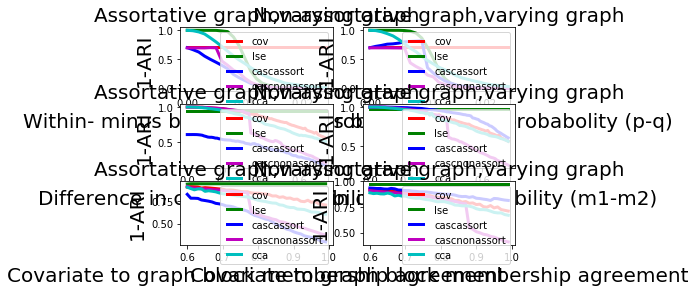

In [2]:

# -*- coding: utf-8 -*-
"""
Created on Mon Nov  4 10:56:43 2019

@author: jerryyao
"""

import matplotlib.pyplot as plt
import numpy as np
x1=np.arange(0,0.025,0.001)
pltlabels=['cov','lse','cascassort','cascnonassort','cca']
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),
     ('longdash',(0,(10,2)))]  # Same as '-.'
#linestyletuple=['r--','k-.','k--','k-','k:']
linestyletuple=['r','g','b','m','c']
ax1=plt.subplot(3, 2, 1)
for i in range(0,5):
    ax1.plot(x1,loss[:,i],linestyletuple[i],linewidth=3)
ax1.legend(pltlabels,numpoints  =200,loc='upper right')

ax1.set_title('Assortative graph,varying graph',fontsize =20)
ax1.set_xlabel('Within- minus between-block probabolity (p-q)',fontsize =20 )
ax1.set_ylabel('1-ARI',fontsize =20)

#plt.figure()
ax2=plt.subplot(3, 2, 2)
for i in range(0,5):
    ax2.plot(x1,loss1[:,i],linestyletuple[i],linewidth=3)
ax2.legend(pltlabels,numpoints  =200,loc='upper right')

ax2.set_title('Non-assortative graph,varying graph',fontsize =20)
ax2.set_xlabel('Within- minus between-block probabolity (p-q)' ,fontsize =20)
ax2.set_ylabel('1-ARI',fontsize =20)



x2=np.arange(0,0.75,0.01)

#plt.figure()
ax3=plt.subplot(3, 2, 3)
for i in range(0,5):
    ax3.plot(x2,loss2[:,i],linestyletuple[i],linewidth=3)
ax3.legend(pltlabels,numpoints  =200,loc='upper right')

ax3.set_title('Assortative graph,varying graph',fontsize =20)
ax3.set_xlabel('Difference in covariate probability (m1-m2)' ,fontsize =20)
ax3.set_ylabel('1-ARI',fontsize =20)


#plt.figure()
ax4=plt.subplot(3, 2, 4)
for i in range(0,5):
    ax4.plot(x2,loss3[:,i],linestyletuple[i],linewidth=3)
ax4.legend(pltlabels,numpoints  =200,loc='upper right')
ax4.set_title('Non-assortative graph,varying graph',fontsize =20)
ax4.set_xlabel('Difference in covariate probability (m1-m2)',fontsize =20)
ax4.set_ylabel('1-ARI',fontsize =20)

x3=np.arange(0.6,1.0,0.01)
#plt.figure()
ax5=plt.subplot(3, 2, 5)
for i in range(0,5):
    ax5.plot(x3,loss5[:,i],linestyletuple[i],linewidth=3)
ax5.legend(pltlabels,numpoints  =200,loc='upper right')


ax5.set_title('Assortative graph,varying graph',fontsize =20)
ax5.set_xlabel('Covariate to graph block membership agreement' ,fontsize =20)
ax5.set_ylabel('1-ARI',fontsize =20)

#plt.figure()
ax6=plt.subplot(3, 2, 6)
for i in range(0,5):
    ax6.plot(x3,loss6[:,i],linestyletuple[i],linewidth=3)
ax6.legend(pltlabels,numpoints  =200,loc='upper right')

ax6.set_title('Non-assortative graph,varying graph',fontsize =20)
ax6.set_xlabel('Covariate to graph block membership agreement',fontsize =20 )
ax6.set_ylabel('1-ARI',fontsize =20)
plt.tight_layout()
plt.show()